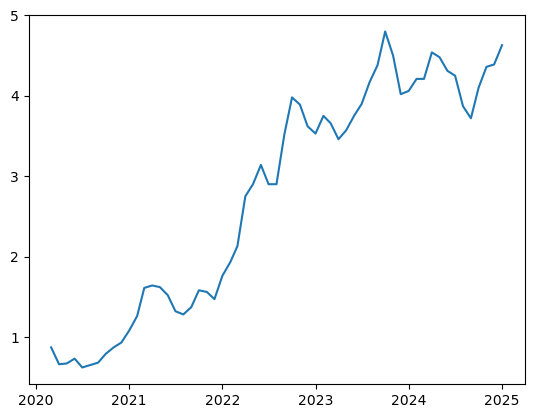

In [1]:
#!pip install pandas_datareader
import pandas_datareader as pdr
gs10=pdr.get_data_fred('GS10')
#GS10是近五年月度美国10年起国债固定收益
#加载并展示数据集
import matplotlib.pyplot as plt
plt.plot(gs10)
plt.show()

数据预处理，对数据进行切分,简单来说，就是划分后，然后规定用几个来预测下一个词，相当于滑动窗口
<img src="attachment:5676a918-f873-438a-b954-b28a19e80806.jpg" alt="Example Image" style="width:888px;height:auto;">

In [3]:
import torch
from torch.utils.data import DataLoader,TensorDataset

num=len(gs10)
x=torch.tensor(gs10['GS10'].to_list())
seq_len=6 #输入序列的长度
batch_size=4

x_feature=torch.zeros((num - seq_len,seq_len)) #全零的特征矩阵，行数为num-seq_len,是因为起始的这个6个数前面没有是数据
for i in range(seq_len):
    x_feature[:,i]=x[i:num-seq_len+i] #这里是填充每一列
    
y_label=x[seq_len:].reshape((-1,1))
train_loader=DataLoader(TensorDataset(x_feature[:num-seq_len], y_label[:num-seq_len] ) ,batch_size=batch_size,shuffle=True)
#构建数据加载器

In [4]:
#先尝试用简单的网络
from torch import nn
from tqdm import *

class Model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.f1=nn.Linear(input_size,hidden_size)
        self.f2=nn.Linear(hidden_size,output_size)

    def forward(self,x):
        output=self.f1(x)
        output=torch.relu(output)
        output=self.f2(output)
        return output

#定义超参数
input_size=seq_len
hidden_size=10
output_size=1
lr=0.01

#构建模型
model=Model(input_size,hidden_size,output_size)
criterion=nn.MSELoss(reduction='none')
'''参数reduction='None'的设置意味着损失函数不会对计算出的每个样本的损失进行任何形式的聚合。
默认情况下，nn.MSELoss的reduction参数可以是'mean'（计算所有样本损失的平均值）或'sum'（计算所有样本损失的总和），
但设置为'None'时，它会返回每个样本的损失作为一个张量（Tensor），不进行任何形式的减少操作。'''
optimizer=torch.optim.Adam(model.parameters(), lr)

#训练
num_epochs=20
loss_history=[]

for epoch in range(num_epochs):
    #x=训练
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred=model(x)
        loss=criterion(y,y_pred)
        loss.sum().backward()
        optimizer.step()
    #评估
    model.eval()
    with torch.no_grad():
        total_loss=0
        for x,y in train_loader:
            y_pred=model(x)
            loss=criterion(y,y_pred)
            total_loss+=loss.sum()/loss.numel()
    avg_loss=total_loss/len(train_loader)
    loss_history.append(avg_loss)
    tqdm.write(f'epoch: {epoch+1}; avg_loss: {avg_loss:.4f}')
    ###为什么不显示进度条

epoch: 1; avg_loss: 0.5480
epoch: 2; avg_loss: 0.4991
epoch: 3; avg_loss: 0.2046
epoch: 4; avg_loss: 0.1361
epoch: 5; avg_loss: 0.1382
epoch: 6; avg_loss: 0.1313
epoch: 7; avg_loss: 0.1340
epoch: 8; avg_loss: 0.1578
epoch: 9; avg_loss: 0.1244
epoch: 10; avg_loss: 0.1219
epoch: 11; avg_loss: 0.1234
epoch: 12; avg_loss: 0.1190
epoch: 13; avg_loss: 0.1378
epoch: 14; avg_loss: 0.1122
epoch: 15; avg_loss: 0.1091
epoch: 16; avg_loss: 0.1188
epoch: 17; avg_loss: 0.1077
epoch: 18; avg_loss: 0.1062
epoch: 19; avg_loss: 0.1065
epoch: 20; avg_loss: 0.1161


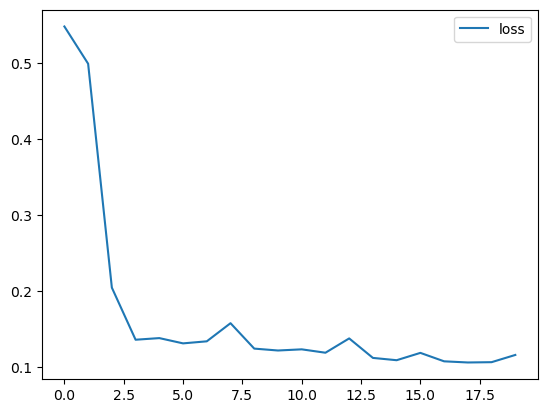

In [5]:
import matplotlib.pyplot as plt
plt.plot(loss_history,label='loss')
plt.legend()
plt.show()

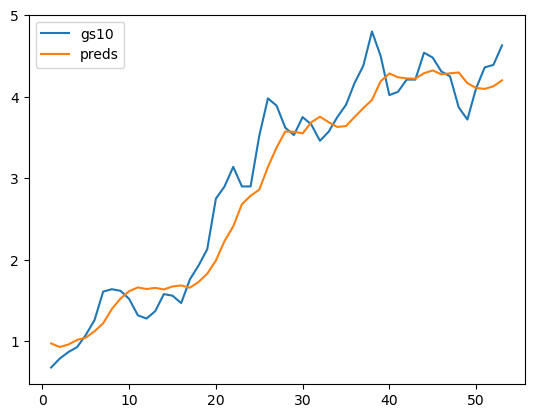

In [18]:
preds=model(x_feature)
time=torch.arange(1,num+1,dtype=torch.float32) #时间轴

plt.plot(time[:num-seq_len],gs10['GS10'].to_list()[seq_len:num],label='gs10')
plt.plot(time[:num-seq_len],preds.detach().numpy(),label='preds')
plt.legend()
plt.show()
#.detach()：这个方法的作用是将一个张量从其计算图中分离出来。
#在PyTorch中，张量是用来存储数据的，而这些数据往往是通过一系列的计算（例如，通过神经网络的前向传播）得到的。
#这些计算构成了一个计算图
#.numpy():将张量转换为数组

In [28]:
#前面是使用简单神经网络预测的 下面使用RNN进行尝试
import torch
from torch.utils.data import DataLoader,TensorDataset

num=len(gs10)
x=torch.tensor(gs10['GS10'].to_list())
seq_len=6
batch_size=4

x_feature=torch.zeros((num-seq_len,seq_len))
y_label=torch.zeros((num-seq_len,seq_len))

for i in range(seq_len):
    x_feature[:,i]=x[i:num-seq_len+i]
    y_label[:,i]=x[i+1:num-seq_len+i+1]

train_loader=DataLoader(TensorDataset(x_feature[:num-seq_len].unsqueeze(2),y_label[:num-seq_len]),batch_size=batch_size)
#unsqueeze(2),对x_feature升维操作


In [56]:
from torch import nn
from tqdm import *

class RNNModel(nn.Module):
    def __init__(self,input_size,output_size,num_hidden,n_layers):
        super(RNNModel,self).__init__()
        self.num_hidden=num_hidden
        self.n_layers=n_layers
        self.rnn=nn.RNN(input_size,num_hidden,n_layers,batch_first=True)
        self.linear=nn.Linear(num_hidden,output_size)

    def forward(self,x):
        batch_size=x.size(0)
        state=self.begin_state(batch_size)
        output,state=self.rnn(x,state) #state是参数权重矩阵
        output=self.linear(torch.relu(output))
        return output,state

    def begin_state(self,batch_size=1):
        return torch.zeros(self.n_layers,batch_size,self.num_hidden)

In [58]:
#定义超参数
input_size=1
output_size=1
num_hidden=10
n_layers=1
lr=0.01

#构建模型
model=RNNModel(input_size,output_size,num_hidden,n_layers)
criterion=nn.MSELoss(reduction='none')
trainer=torch.optim.Adam(model.parameters(),lr)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 48.98it/s]


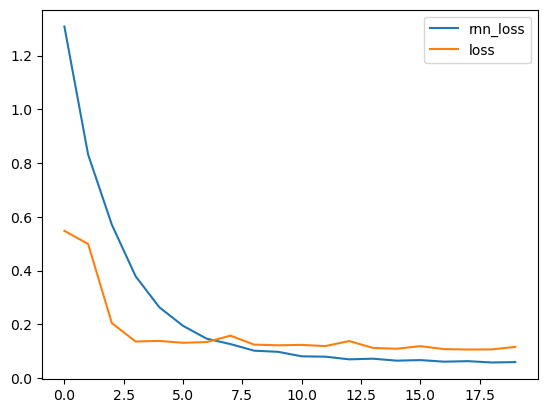

In [68]:
num_epochs=20
rnn_loss_history=[]

for epoch in tqdm(range(num_epochs)):
    model.train()
    for x,y in train_loader:
        trainer.zero_grad()
        y_pred,state=model(x)
        loss=criterion(y_pred.squeeze(), y.squeeze())
        loss.sum().backward()
        trainer.step()

    model.eval()
    with torch.no_grad():
        total_loss=0
        for x,y in train_loader:
            y_pred,state=model(x)
            loss=criterion(y_pred.squeeze(), y.squeeze())
            total_loss+=loss.sum()/loss.numel()
        avg_loss=total_loss/len(train_loader)
        rnn_loss_history.append(avg_loss)

import matplotlib.pyplot as plot
plt.plot(rnn_loss_history,label='rnn_loss')
plt.plot(loss_history,label='loss')
plt.legend()
plt.show()

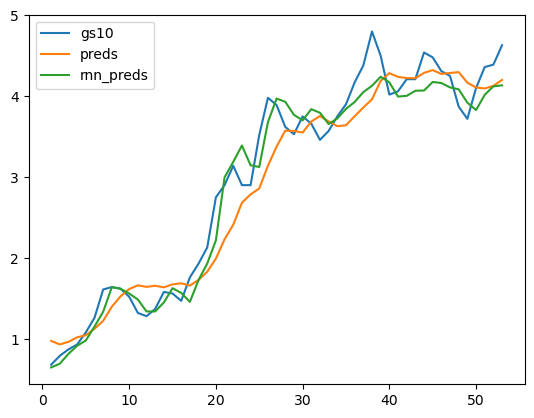

In [72]:
rnn_preds,_=model(x_feature.unsqueeze(2))
preds.squeeze()
time=torch.arange(1,num+1,dtype=torch.float32)
plt.plot(time[:num-seq_len],gs10['GS10'].to_list()[seq_len:num],label='gs10')
plt.plot(time[:num-seq_len],preds.detach().numpy(),label='preds')
plt.plot(time[:num-seq_len],rnn_preds[:,seq_len-1].detach().numpy(),label='rnn_preds')
plt.legend()
plt.show()

In [1]:
print('yes')

yes
